# Breast Cancer Classification ML Pipeline


---
## Author -- Rossi Anna

This project presents a machine learning pipeline for breast cancer classification based on morphological features extracted from cell nuclei. It covers stage as exploratory data analysis and preprocessing to model training, evaluation, and feature selection. The main objective is to compare the performance of various classification algorithms distinguishing between malignant and benign breast tumors:
* Logistic Regression
* Linear Discriminant Analysis
* k-Nearest Neighbors
* Classification and Regression Trees
* Naive Bayes
* Support Vector Machinesin accurately


---

## Background

Breast cancer is a leading cause of cancer mortality in women. Early identification is crucial to improving prognosis. This design uses nuclear features derived from fine needle aspiration (FNA) images to distinguish between benign (class 0) and malignant (class 1) cells.

> **"Malignant nuclei tend to be larger and to have shapes that are more variable, less smooth, and less symmetric than benign nuclei."**
*Street, William Nick et al. “Nuclear feature extraction for breast tumor diagnosis.” Electronic imaging (1993).*

To quantify this *irregularity*, several morphological measures are used:

- **Perimeter**: Total length of the nucleus outline  
- **Area**: Size of the nucleus  
- **Radius**: Average distance from center to perimeter  
- **Smoothness**: Local variation in radius lengths  
- **Compactness**,
- **Concavity**,
- **Concave Points**: Describe how hollowed out, serrated, or fragmented the outline is

---

## Dataset Overview
> **SOURCE** - UCI Machine Learning Repository (Breast Cancer Wisconsin Diagnostic Dataset)

- **Samples**: 569 breast cell nuclei (357 benign, 212 malignant)
- **Features**: 30 real-valued descriptors extracted from each image
- **Classes**:
  - `0` → **Benign** (non-cancerous)
  - `1` → **Malignant** (cancerous)

---

## Feature Structure

For each cell nucleus, **10 basic features** are calculated:

| Feature             | Description |
|---------------------|-------------|
| `Radius`            | Mean of distances from center to points on the perimeter |
| `Texture`           | Standard deviation of gray-scale values |
| `Perimeter`         | Length of the nucleus contour |
| `Area`              | Area enclosed by the contour |
| `Smoothness`        | Local variation in radius lengths |
| `Compactness`       | (Perimeter² / Area) - 1.0 |
| `Concavity`         | Severity of concave portions of the contour |
| `Concave Points`    | Number of concave portions on the contour |
| `Symmetry`          | Symmetry of the nucleus shape |
| `Fractal Dimension` | Approximation of the contour's fractal dimension |

For each of these 10 features, **three statistical values** are computed:

- **Mean**: Average across all measurements  
- **Standard Error**: Standard error of the mean  
- **Worst**: Mean of the three largest values  



---
## **0. Initial set up**

In [139]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
from matplotlib import pyplot
import seaborn as sns

# Preprocessing
from numpy import set_printoptions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# Evaluation metrices
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, matthews_corrcoef, f1_score

### Exporting Pipeline Results

All key outputs—datasets, models, metrics, and plots—are automatically saved using a dedicated Python script.

In [140]:
!rm saving.py

In [141]:
from google.colab import files
uploaded = files.upload()
!cat saving.py

Saving saving.py to saving.py
import os
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import subprocess


# 1. Setup folders
def setup_folders():
    """Create the folder structure for the project"""
    folders = [
        'data',
        'models',
        'figures',
    ]

    for folder in folders:
        os.makedirs(folder, exist_ok=True)
        print(f"Folder created: {folder}")


# 2. Function to save datasets
def save_dataset(df, name):
    """Save a dataframe in CSV format"""
    path = f'data/{name}'
    df.to_csv(f'{path}.csv', index=False)
    print(f"Dataset saved: {path}.*")


# 3. Function to save plot
def save_plot(fig, name, tight_layout=True):
    """Save a figure in PNG"""
    path = f'figures/{name}'
    if tight_layout:
        plt.tight_layout()
    fig.savefig(f'{path}.png', dpi=300, bbox_inches='tight')
    print(f"Plot saved: {path}.*")
    plt.close()


# 4. Function to save models
def save_model(model, name):
    """Save a template in job

In [142]:
import saving
import importlib
importlib.reload(saving)
saving.setup_folders()

Folder created: data
Folder created: models
Folder created: figures


---
## **1. Download and dataset preparation**

Download form the following link https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic the .data file containg all the data

In [143]:
!wget -O breast.data "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

--2025-08-07 09:52:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘breast.data’

breast.data             [ <=>                ] 121.19K   702KB/s    in 0.2s    

2025-08-07 09:52:23 (702 KB/s) - ‘breast.data’ saved [124103]



Using the *wdbc.names* file add the specific label to each column and row at the dataset *breast.data*

In [144]:
columns = ['ID', 'Diagnosis'] + [
    f"{feature}_{stat}"
    for stat in ['mean', 'se', 'worst']
    for feature in [
        'radius', 'texture', 'perimeter', 'area', 'smoothness',
        'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension'
    ]
]

Now we can convert the dataset in a dataframe and saving a clean copy of it for future use.

In [145]:
df = pd.read_csv("breast.data", header=None, names=columns)
df.to_csv('breast.cvs', index= False)
saving.save_dataset(df, 'breast_df.csv')
df.head()

Dataset saved: data/breast_df.csv.*


,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [146]:
# identify possible null values
df.isnull().sum()

,0
ID,0
Diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave_points_mean,0


In [147]:
# check the size of the dataset
df.shape

(569, 32)

In [148]:
# some general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       569 non-null    int64  
 1   Diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [149]:
# check the columns label
df.columns

Index(['ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

---
## **2. Exploratory Data Analysis**

### **2.1 Class distribution**

We know that the dataset is skeweed between the two class. We can visualize it using a bar plot

In [150]:
# check the size of the two class (Malignant and Benignant)
class_count = df.groupby('Diagnosis').size()
print(class_count)

Diagnosis
B    357
M    212
dtype: int64


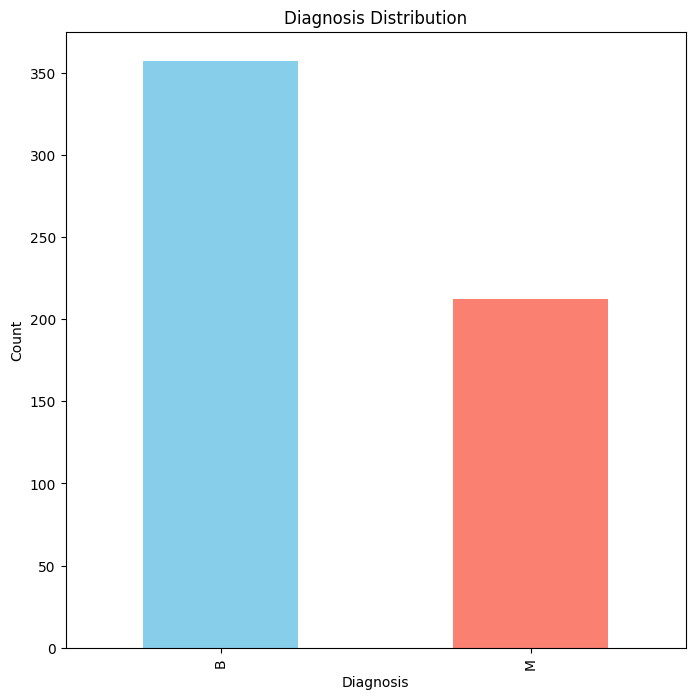

Plot saved: figures/Diagnosis_distribution.*


In [151]:
pyplot.figure(figsize=(8,8)) # Create a figure
ax = class_count.plot(kind='bar', color=['skyblue', 'salmon']) # Plot returns Axes object

pyplot.title('Diagnosis Distribution')
pyplot.xlabel('Diagnosis')
pyplot.ylabel('Count')
pyplot.show()

# Saving
saving.save_plot(ax.get_figure(), 'Diagnosis_distribution') # Get the Figure from the Axes and save it

### **2.2 Density distribution of features**
Visualizing the overall distribution of each feature to understand their statistical properties and detect potential skewness, outliers, or class separation patterns.


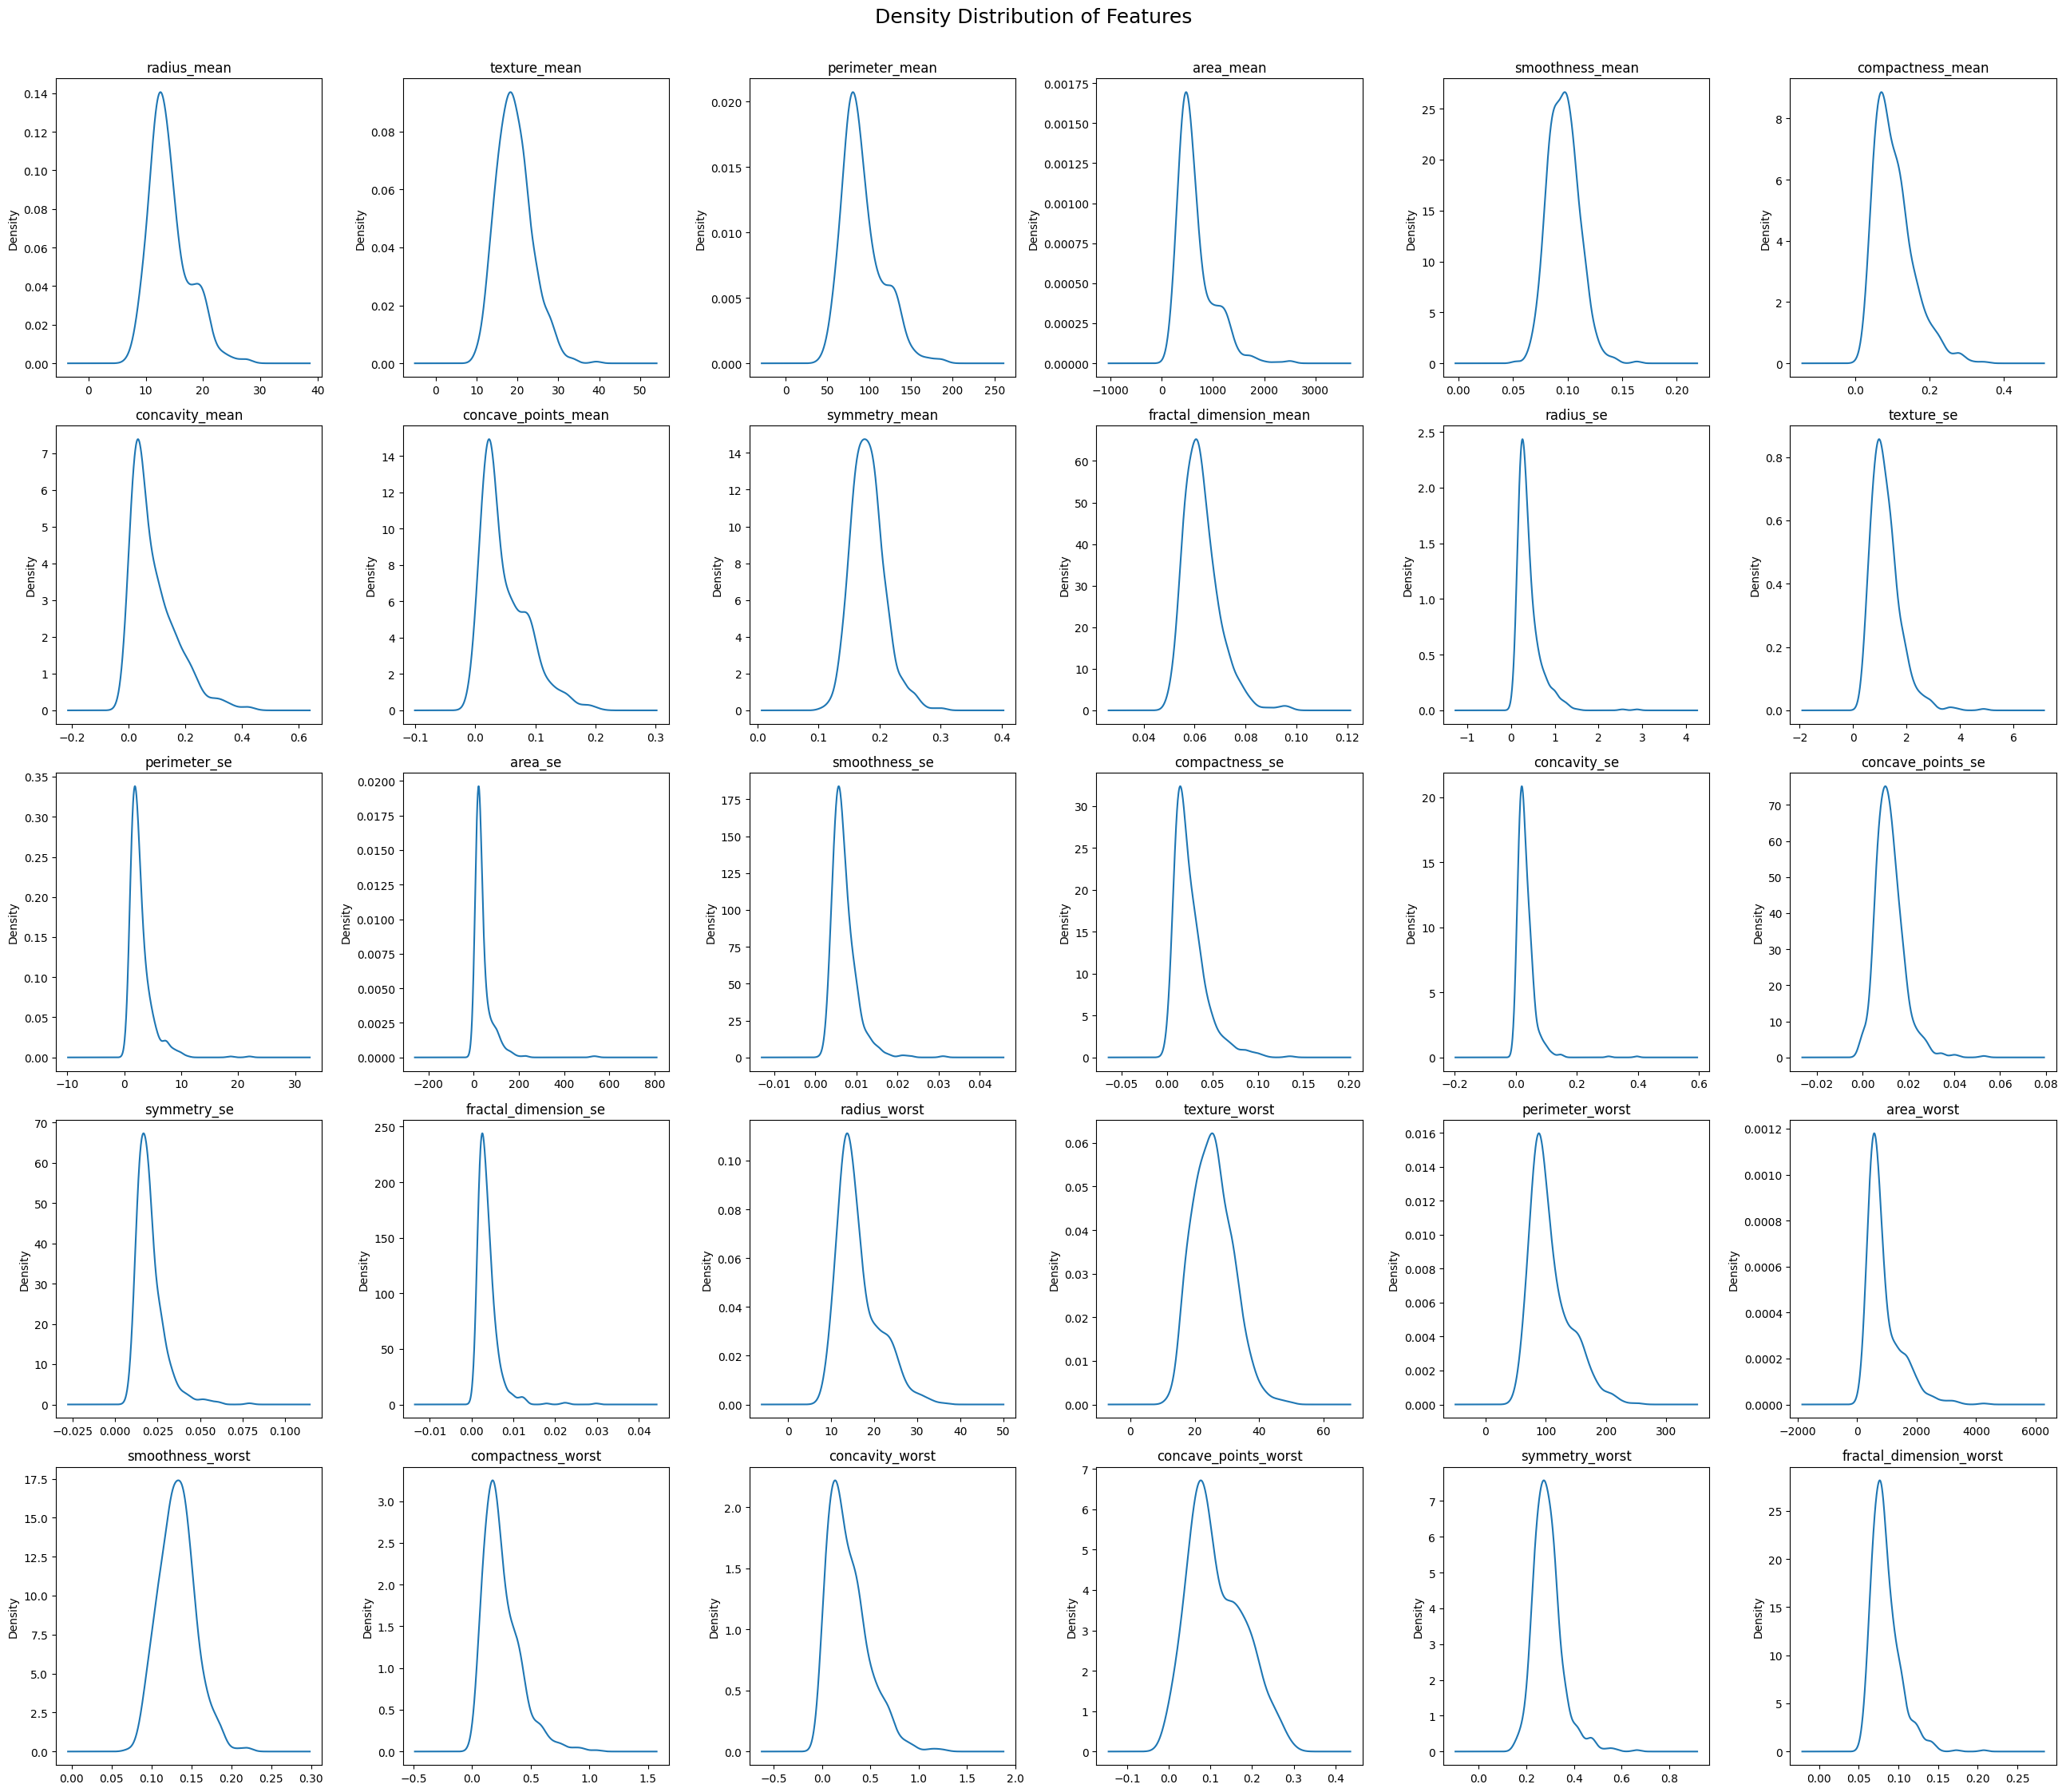

Plot saved: figures/Density_distribution.*


In [152]:
fig, axes = pyplot.subplots(nrows=6, ncols=6, figsize=(26, 26)) # Create figure and axes
axes = axes.flatten() # Flatten the 2D array of axes

# Plot density for each column, excluding 'ID' and 'Diagnosis'
features = df.columns.drop(['ID', 'Diagnosis'])
for i, feature in enumerate(features):
    if i < len(axes): # Ensure there is an axis for the feature
        df[feature].plot(kind='density', ax=axes[i])
        axes[i].set_title(feature)
        axes[i].legend().remove() # Remove individual subplot legends to avoid clutter

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

pyplot.tight_layout()
pyplot.suptitle('Density Distribution of Features', y=1.02, fontsize=18)
pyplot.show()

# Saving the figure
saving.save_plot(fig, 'Density_distribution')

### **2.3 Box plot of features distribution by diagnosis**
Comparing the distribution of each feature across benign and malignant cases highlights the most discriminative features.

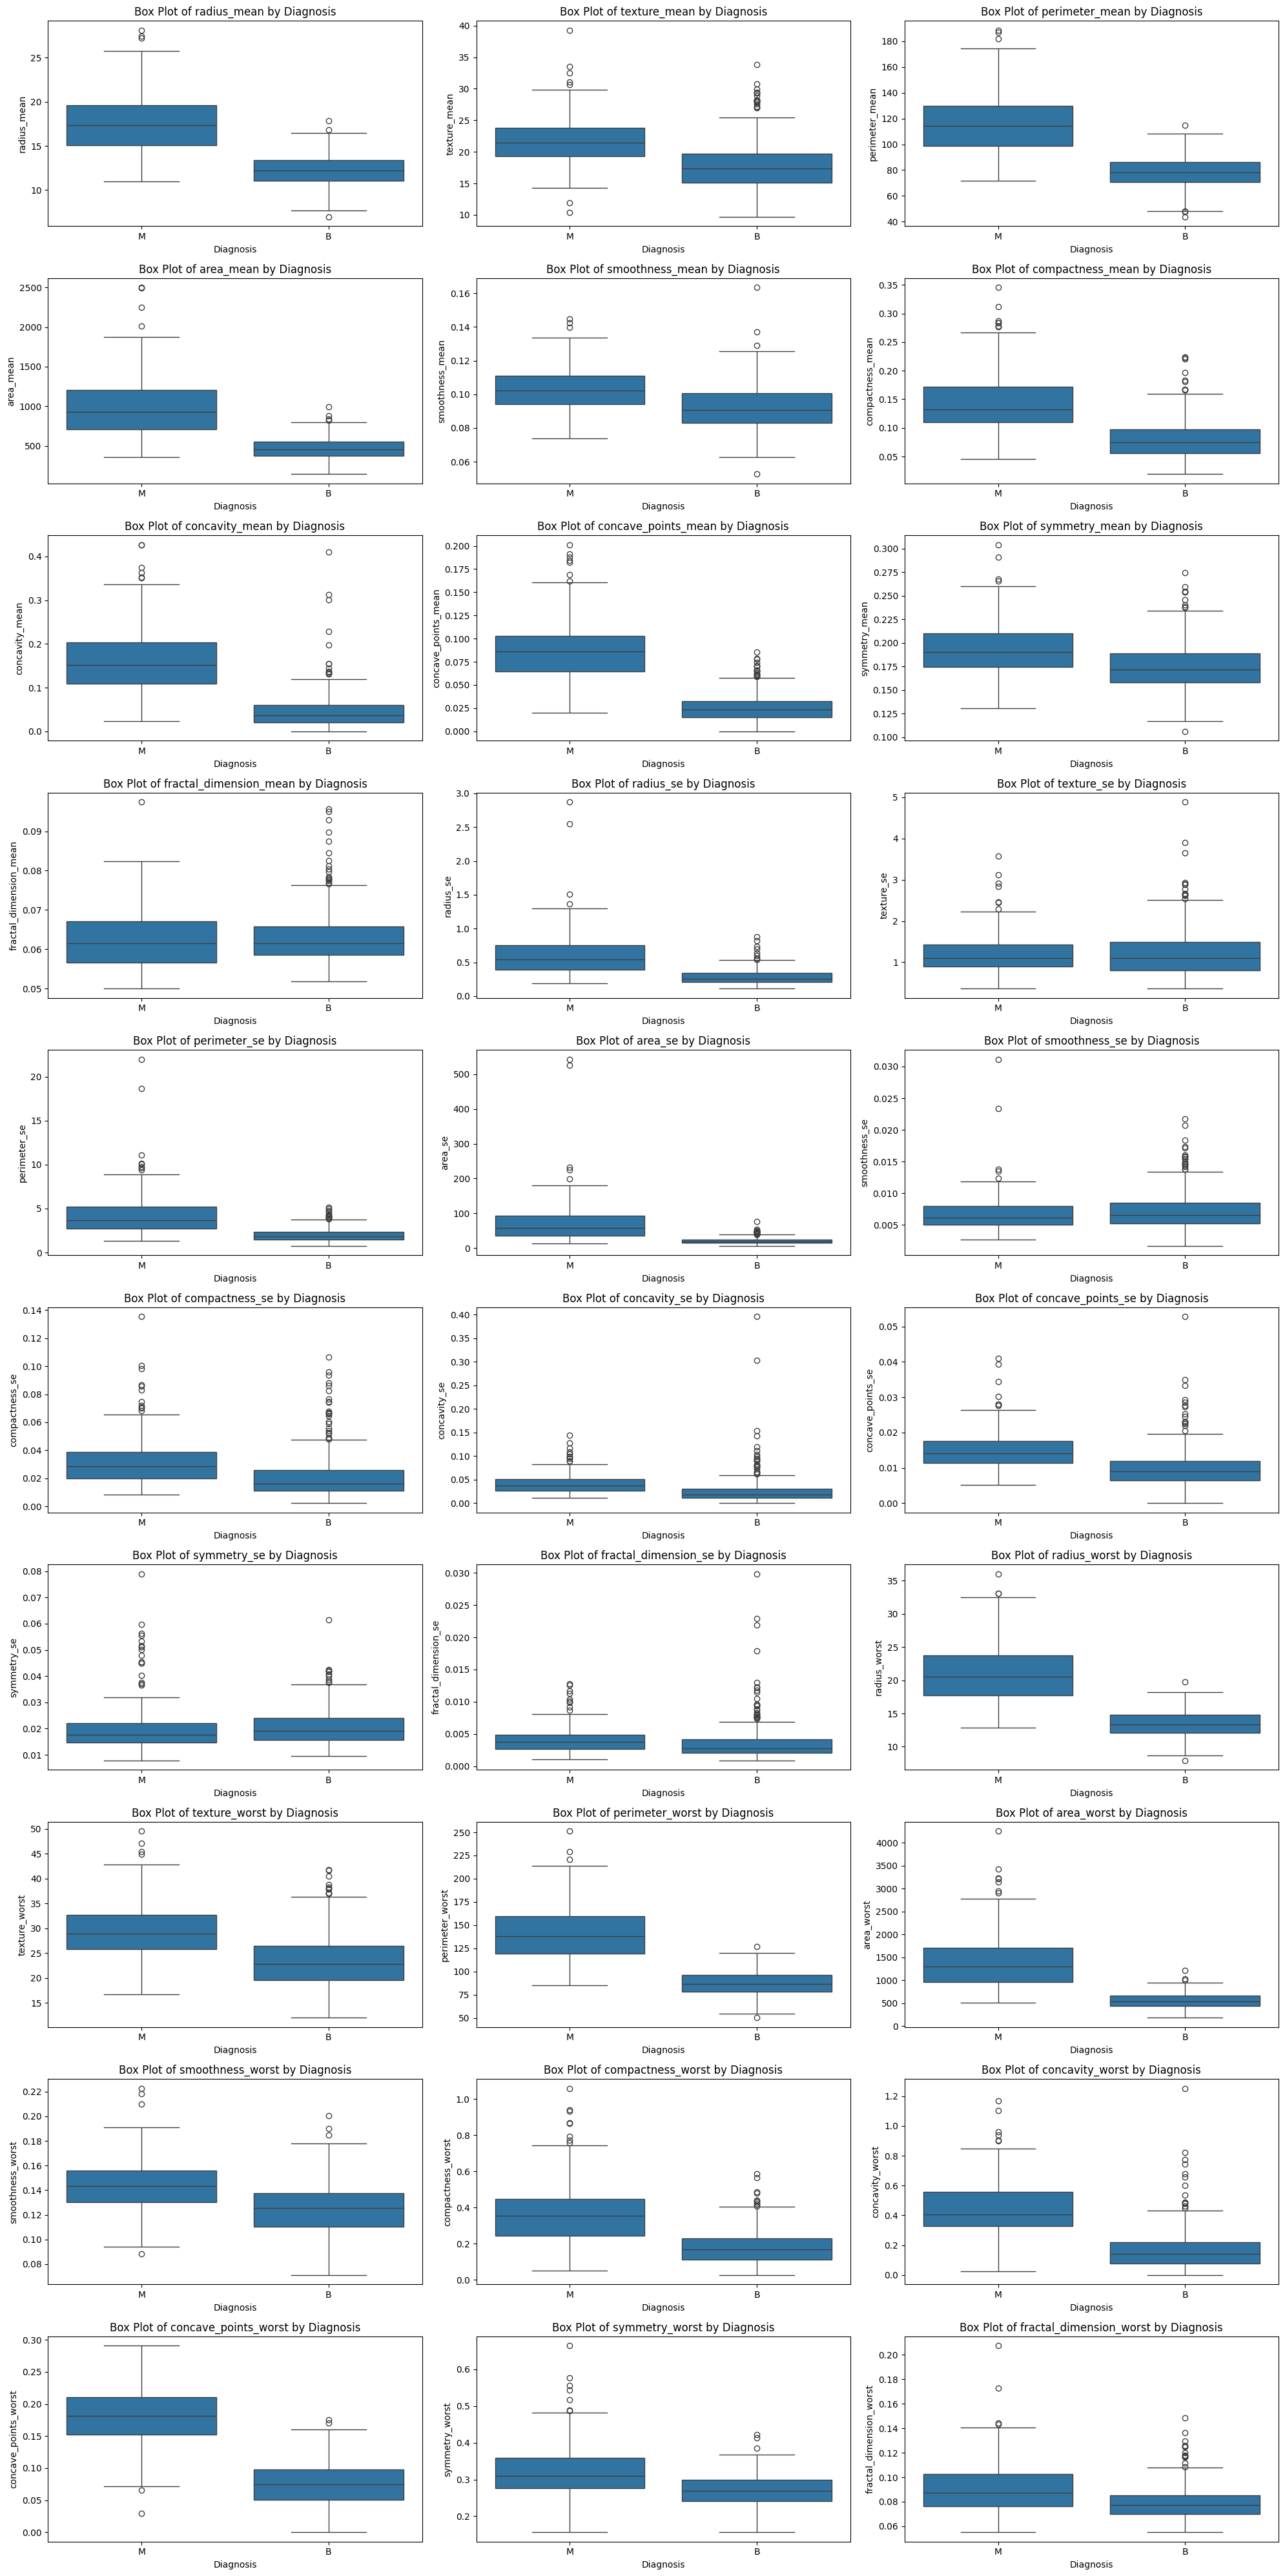

Plot saved: figures/Boxplot_by_diagnosis.*


In [153]:
# List of features to plot
features = df.columns.drop(['ID', 'Diagnosis'])

# Set up the plot grid
fig = pyplot.figure(figsize=(20, 40))
for i, feature in enumerate(features, 1):
    pyplot.subplot(10, 3, i)
    sns.boxplot(data=df, x='Diagnosis', y=feature)
    pyplot.title(f'Box Plot of {feature} by Diagnosis', fontsize=12)
    pyplot.xlabel('Diagnosis')
    pyplot.ylabel(feature)
    pyplot.tight_layout()
pyplot.show()

# Saving
saving.save_plot(fig, 'Boxplot_by_diagnosis')

### **2.4 Heatmap of correlation**
A heatmap of Pearson correlations between all features helps identify strong linear relationships, multicollinearity, and potential redundancy. Highly correlated features may convey similar information and can influence model performance and interpretability.

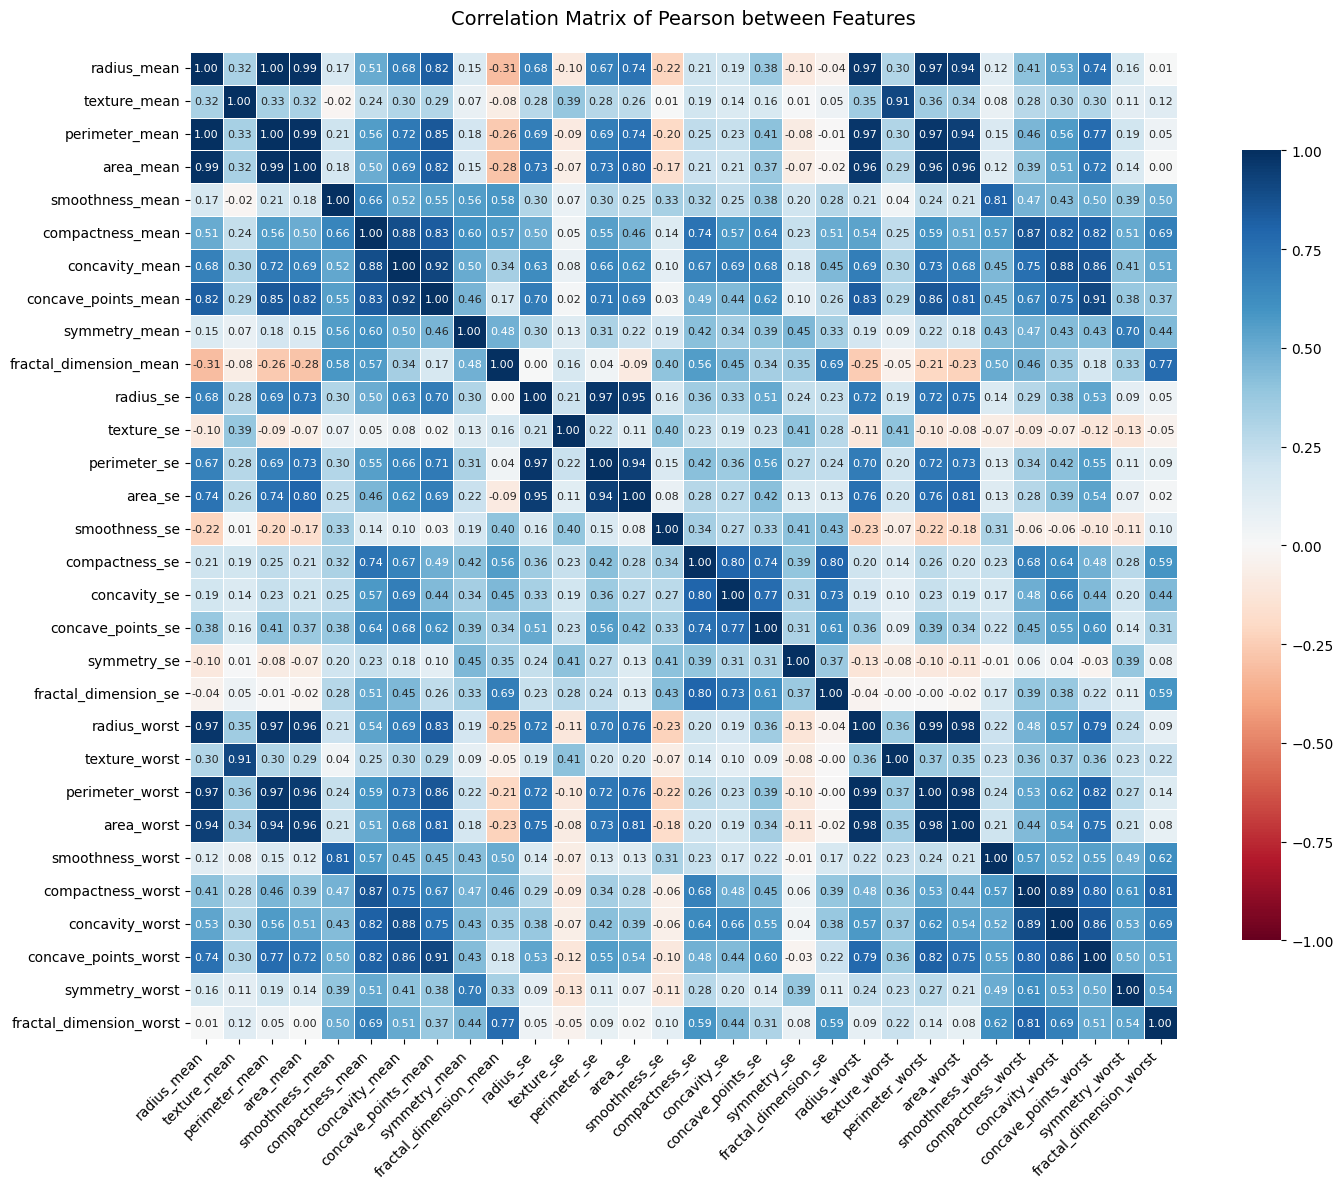

Plot saved: figures/Correlation_matrix.*


In [154]:
df_numeric = df.drop(columns=['ID','Diagnosis'])

# Calculate correlation matrix
correlation = df_numeric.corr()

fig = pyplot.figure(figsize=(15, 12))

sns.heatmap(correlation,
            cmap='RdBu',
            vmin=-1,
            vmax=1,
            center=0,
            annot=True,
            fmt=".2f",
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .8},
            annot_kws={'size': 8})

pyplot.xticks(rotation=45, ha='right')
pyplot.yticks(rotation=0)
pyplot.title('Correlation Matrix of Pearson between Features', pad=20, fontsize=14)

pyplot.tight_layout()
pyplot.show()

# Saving
saving.save_plot(fig, 'Correlation_matrix')

We can find the most correlated features, with a correlation >0.95 for interpret at best the Confusion Matrix

In [155]:
high_corr = np.where(np.abs(correlation) > 0.95)
high_corr = [(correlation.columns[x], correlation.columns[y], round(correlation.iloc[x,y], 2))
             for x,y in zip(*high_corr) if x!=y and x<y]

print("Correlated Fetures (> 0.95):")
for pair in high_corr:
    print(f"{pair[0]} - {pair[1]}: {pair[2]}")

Correlated Fetures (> 0.95):
radius_mean - perimeter_mean: 1.0
radius_mean - area_mean: 0.99
radius_mean - radius_worst: 0.97
radius_mean - perimeter_worst: 0.97
perimeter_mean - area_mean: 0.99
perimeter_mean - radius_worst: 0.97
perimeter_mean - perimeter_worst: 0.97
area_mean - radius_worst: 0.96
area_mean - perimeter_worst: 0.96
area_mean - area_worst: 0.96
radius_se - perimeter_se: 0.97
radius_se - area_se: 0.95
radius_worst - perimeter_worst: 0.99
radius_worst - area_worst: 0.98
perimeter_worst - area_worst: 0.98


---
## **Data preparation**

1. **RESCALING THE DATA**

The features have different scales and Logistic Regression is scale-sensible. I choose to apply the *Sklearn*'s tool **StandardScaler**, which transforms each feature to obtain a 0 mean and 1 Standard Deviation.


In [156]:
features = df.columns.drop(['ID', 'Diagnosis'])
X = df[features].values

# Convert 'Diagnosis' to numerical labels: 'M' -> 1, 'B' -> 0
Y = df['Diagnosis'].map({'M': 1, 'B': 0}).values

# Split into Train and Test Sets --> Training(80%), Test(20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

set_printoptions(precision=3)

# Check the Standardization
print('\nCheck Standardization:')
print(f'Mean train original: {X_train.mean():.2f}')
print(f'Mean train scaled: {X_train_scaled.mean():.2f} (should be near 0)')
print(f'Std train original: {X_train.std():.2f}')
print(f'Std train scaled: {X_test_scaled.std():.2f} (should be near 1)')

# Visualize the most significant
print('\nFirst 5 values of the first feature:')
print('Not scaled:', X_train[:5, 0])
print('Scaled:', X_train_scaled[:5, 0], '\n')

# Saving
saving.save_dataset(pd.DataFrame(X_train), 'X_train')
saving.save_dataset(pd.DataFrame(X_test), 'X_test')
saving.save_dataset(pd.DataFrame(Y_train), 'Y_train')
saving.save_dataset(pd.DataFrame(Y_test), 'Y_test')
saving.save_dataset(pd.DataFrame(X_train_scaled), 'X_train_scaled')
saving.save_dataset(pd.DataFrame(X_test_scaled), 'X_test_scaled')



Check Standardization:
Mean train original: 62.46
Mean train scaled: -0.00 (should be near 0)
Std train original: 231.42
Std train scaled: 0.93 (should be near 1)

First 5 values of the first feature:
Not scaled: [16.02 12.32 12.85 14.9  18.61]
Scaled: [ 0.519 -0.516 -0.368  0.205  1.243] 

Dataset saved: data/X_train.*
Dataset saved: data/X_test.*
Dataset saved: data/Y_train.*
Dataset saved: data/Y_test.*
Dataset saved: data/X_train_scaled.*
Dataset saved: data/X_test_scaled.*


2. **FEATURE SELECTION**

This step is important to reduce overfitting, improve the accuracy, and reduce the training time.

*https://scikit-learn.org/stable/modules/feature_selection.html*

--> **Univariate Selection with SelectKBest - ANOVA f_classif**

Used for selecting the best features based on univariate statistical tests.

In [157]:
# Evalutae the optimal k value
result_US = []

for k in range(5,31):
  select = SelectKBest(score_func=f_classif, k=k)
  X_train_k = select.fit_transform(X_train_scaled, Y_train)

  model = LogisticRegression(solver='lbfgs', max_iter=5000)
  cv_score = cross_val_score(model, X_train_k, Y_train, cv=5, scoring='accuracy')
  mean_acc = np.mean(cv_score)
  result_US.append((k,mean_acc))


max_acc = 0
for k,acc in result_US:
  print('K=', k, '--> Accuracy= ', acc)
  if acc > max_acc:
    max_acc = acc
    k_val = k

print('\nThe max accurancy [', max_acc, '] is obtained with this k value: ', k_val)

K= 5 --> Accuracy=  0.9384615384615385
K= 6 --> Accuracy=  0.9428571428571428
K= 7 --> Accuracy=  0.9428571428571428
K= 8 --> Accuracy=  0.9428571428571428
K= 9 --> Accuracy=  0.9472527472527472
K= 10 --> Accuracy=  0.9516483516483518
K= 11 --> Accuracy=  0.945054945054945
K= 12 --> Accuracy=  0.9428571428571428
K= 13 --> Accuracy=  0.9340659340659341
K= 14 --> Accuracy=  0.9362637362637363
K= 15 --> Accuracy=  0.9406593406593406
K= 16 --> Accuracy=  0.9670329670329672
K= 17 --> Accuracy=  0.9670329670329672
K= 18 --> Accuracy=  0.9714285714285715
K= 19 --> Accuracy=  0.9758241758241759
K= 20 --> Accuracy=  0.9736263736263737
K= 21 --> Accuracy=  0.9736263736263737
K= 22 --> Accuracy=  0.9736263736263737
K= 23 --> Accuracy=  0.9714285714285715
K= 24 --> Accuracy=  0.9736263736263737
K= 25 --> Accuracy=  0.9736263736263737
K= 26 --> Accuracy=  0.9736263736263737
K= 27 --> Accuracy=  0.9736263736263737
K= 28 --> Accuracy=  0.9736263736263737
K= 29 --> Accuracy=  0.9714285714285715
K= 30 

In [158]:
select = SelectKBest(score_func=f_classif, k=k_val)
select.fit(X_train_scaled, Y_train)
selected_mask_UN = select.get_support()

selected_features_UN = df.columns.drop(['ID', 'Diagnosis'])[selected_mask_UN]

print("Selected features (KBest):")
print(selected_features_UN.tolist())
print('\nNumber of selected features up to initial 32: ', len(selected_features_UN))

Selected features (KBest):
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'radius_se', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst']

Number of selected features up to initial 32:  19


--> **Recursive Feature Elimination (RFE)**

Recursively delete less important features based on the model until you get the desired number.

In [159]:
result_RFE = []
model = LogisticRegression(solver='lbfgs', max_iter= 5000)

for k in range(5, 31):
    rfe = RFE(estimator=model, n_features_to_select=k)
    X_train_rfe = rfe.fit_transform(X_train_scaled, Y_train)

    cv_scores = cross_val_score(model, X_train_rfe, Y_train, cv=5, scoring='accuracy')
    mean_acc = np.mean(cv_scores)
    result_RFE.append((k, mean_acc))

max_acc = 0
for k,acc in result_RFE:
  print('K=', k, '--> Accurancy= ', acc)
  if acc > max_acc:
    max_acc = acc
    k_val = k

print('\nThe max accurancy [', max_acc, '] is obtained with this k value: ', k_val)

K= 5 --> Accurancy=  0.9604395604395604
K= 6 --> Accurancy=  0.9692307692307693
K= 7 --> Accurancy=  0.9626373626373628
K= 8 --> Accurancy=  0.9626373626373628
K= 9 --> Accurancy=  0.9626373626373628
K= 10 --> Accurancy=  0.9714285714285715
K= 11 --> Accurancy=  0.9714285714285715
K= 12 --> Accurancy=  0.9692307692307693
K= 13 --> Accurancy=  0.9714285714285715
K= 14 --> Accurancy=  0.9714285714285715
K= 15 --> Accurancy=  0.9714285714285715
K= 16 --> Accurancy=  0.9714285714285715
K= 17 --> Accurancy=  0.9758241758241759
K= 18 --> Accurancy=  0.9714285714285715
K= 19 --> Accurancy=  0.9736263736263737
K= 20 --> Accurancy=  0.9736263736263737
K= 21 --> Accurancy=  0.9758241758241759
K= 22 --> Accurancy=  0.9758241758241759
K= 23 --> Accurancy=  0.9758241758241759
K= 24 --> Accurancy=  0.9736263736263737
K= 25 --> Accurancy=  0.9758241758241759
K= 26 --> Accurancy=  0.9736263736263737
K= 27 --> Accurancy=  0.9714285714285715
K= 28 --> Accurancy=  0.9714285714285715
K= 29 --> Accurancy= 

In [160]:
rfe = RFE(LogisticRegression(max_iter=10000), n_features_to_select=k_val)
rfe.fit(X_train_scaled, Y_train)

selected_mask_RFE = rfe.get_support()
selected_features_RFE = df.columns.drop(['ID', 'Diagnosis'])[selected_mask_RFE]

print("Selected features (RFE):")
print(selected_features_RFE.tolist())
print('\nNumber of selected features up to initial 32: ', len(selected_features_RFE))

Selected features (RFE):
['radius_mean', 'texture_mean', 'area_mean', 'concavity_mean', 'concave_points_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst']

Number of selected features up to initial 32:  17


In [161]:
# Combine the features that were chosen in common by both models
common_features = list(set(selected_features_UN) & set(selected_features_RFE))

In [162]:
# Create a new small dataset only with the common features selected with the Feature Selection part
X = df[common_features].values
# Convert 'Diagnosis' to numerical labels: 'M' -> 1, 'B' -> 0
y = df['Diagnosis'].map({'M': 1, 'B': 0}).values

# Apply again the Feature Scaling
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train_sel)
X_test_scaled_selected = scaler.transform(X_test_sel)

print('\n=== Check Feature Scaling ===')
print('Number of selected features: ', len(common_features))
print('Common features:')
for i in common_features:
  print('-',i)
print("\n First 5 features (before the scaling):\n", X_train_sel[:5, :])
print("\nFirst 5 features (after the scaling):\n", X_train_scaled_selected[:5, :])
print("\nMean after the scaling (shold be ~0):", X_train_scaled_selected.mean(axis=0))
print("\nStd after the scaling (should be ~1):", X_train_scaled_selected.std(axis=0), '\n')


saving.save_dataset(pd.DataFrame(X_train_sel),'X_train_sel')
saving.save_dataset(pd.DataFrame(X_test_sel),'X_test_sel')
saving.save_dataset(pd.DataFrame(y_train_sel),'y_train_sel')
saving.save_dataset(pd.DataFrame(y_test_sel),'y_test_sel')


=== Check Feature Scaling ===
Number of selected features:  16
Common features:
- concavity_worst
- perimeter_worst
- concave_points_mean
- area_mean
- area_se
- radius_se
- radius_worst
- area_worst
- concave_points_worst
- symmetry_worst
- concavity_mean
- texture_mean
- radius_mean
- smoothness_worst
- texture_worst
- perimeter_se

 First 5 features (before the scaling):
 [[1.459e-01 1.238e+02 3.323e-02 7.978e+02 4.051e+01 3.795e-01 1.919e+01
  1.150e+03 9.975e-02 2.948e-01 3.299e-02 2.324e+01 1.602e+01 1.181e-01
  3.388e+01 2.466e+00]
 [1.242e-01 8.697e+01 3.700e-02 4.641e+02 1.743e+01 2.360e-01 1.350e+01
  5.491e+02 9.391e-02 2.827e-01 3.987e-02 1.239e+01 1.232e+01 1.385e-01
  1.564e+01 1.670e+00]
 [1.838e-01 9.163e+01 1.867e-02 5.145e+02 4.124e+01 4.993e-01 1.440e+01
  6.458e+02 5.601e-02 2.488e-01 6.126e-02 2.137e+01 1.285e+01 9.402e-02
  2.701e+01 2.552e+00]
 [9.019e-01 1.254e+02 9.711e-02 6.850e+02 2.419e+01 2.530e-01 1.635e+01
  8.327e+02 2.475e-01 2.866e-01 2.733e-01 2.253e

---
## **Model Training**
    
Now we'll train Logistic Regression models using two different feature sets (all and only selected) and compare their performance.
The evaluation was performed using **K-fold cross_validation** tring different k value (3,5,10) on the training set.

*   **Train with all the 30 features**

In [163]:
%%time
# Evaluate using Cross Validation
num_folds = [3,5,10]
seed = 2

result_kfold = []

for num in num_folds:
  kfold = KFold(n_splits=num, random_state=seed, shuffle=True)
  model = LogisticRegression(solver='lbfgs', max_iter=300)
  results = cross_val_score(model, X_train_scaled, Y_train, cv=kfold)
  result_kfold.append(
    f"Splits: {num} → Accuracy: {results.mean() * 100:.2f}% ± {results.std() * 100:.2f}%"
)

for i in result_kfold:
  print(i)

Splits: 3 → Accuracy: 96.92% ± 0.82%
Splits: 5 → Accuracy: 96.70% ± 1.55%
Splits: 10 → Accuracy: 97.36% ± 2.73%
CPU times: user 271 ms, sys: 2.01 ms, total: 273 ms
Wall time: 145 ms


*   Train only with **selected features** obtained using the Univariate feature selection and the Recursive feature elimination (intersection of two obtained list)



In [164]:
%%time
# Evaluate using Cross Validation
num_folds = [3,5,10]
seed = 2

result_kfold_select = []

for num in num_folds:
  kfold = KFold(n_splits=num, random_state=seed, shuffle=True)
  #model = LogisticRegression()
  model = LogisticRegression(solver='lbfgs', max_iter=300)
  results = cross_val_score(model, X_train_scaled_selected, y_train_sel, cv=kfold)
  result_kfold_select.append(
    f"Splits: {num} → Accuracy: {results.mean() * 100:.2f}% ± {results.std() * 100:.2f}%"
)

for i in result_kfold_select:
  print(i)

Splits: 3 → Accuracy: 96.70% ± 0.01%
Splits: 5 → Accuracy: 96.92% ± 0.44%
Splits: 10 → Accuracy: 97.36% ± 1.64%
CPU times: user 234 ms, sys: 956 µs, total: 235 ms
Wall time: 123 ms


## **Compare ML algorithms to select the best**

Comparison of 6 different ML models, using only the selected features,based on 10-fold cross-validation to find the one with a better accuracy.


* Logistic Regression
* Linear Discriminant Analysis
* k-Nearest Neighbors
* Classification and Regression Trees
* Naive Bayes
* Support Vector Machines



 Optimizing Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Model saved: models/logistic_regression.joblib

🔹 Best Model: Logistic Regression
Accuracy: 0.9825
AUC: 0.9977
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



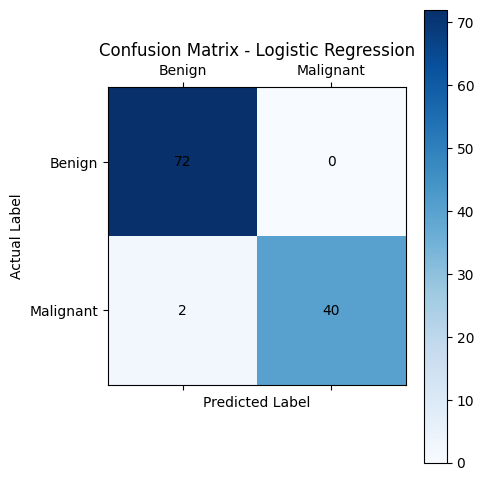

Plot saved: figures/confusion_matrix_logistic_regression.*


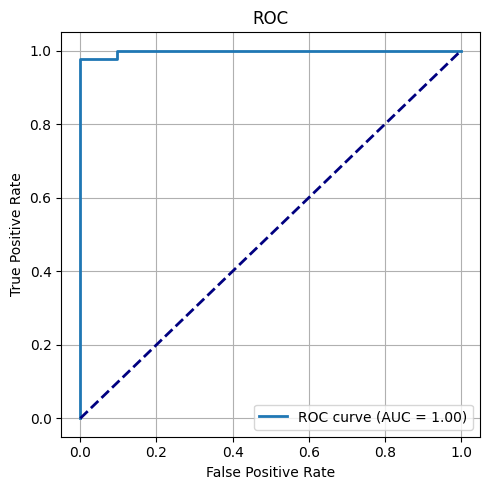

Plot saved: figures/roc_curve_logistic_regression.*

 Optimizing K-Nearest Neighbors...
Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Model saved: models/k-nearest_neighbors.joblib

🔹 Best Model: K-Nearest Neighbors
Accuracy: 0.9386
AUC: 0.9825
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



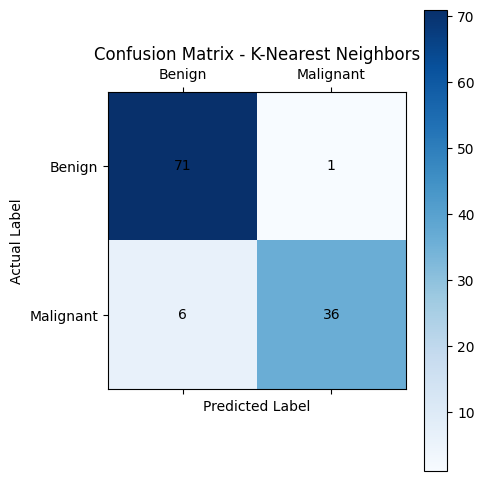

Plot saved: figures/confusion_matrix_k-nearest_neighbors.*


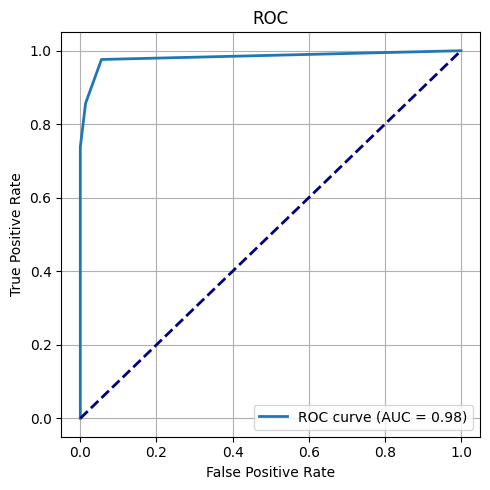

Plot saved: figures/roc_curve_k-nearest_neighbors.*

 Optimizing Support Vector Machine...
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Model saved: models/support_vector_machine.joblib

🔹 Best Model: Support Vector Machine
Accuracy: 0.9737
AUC: 0.9947
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



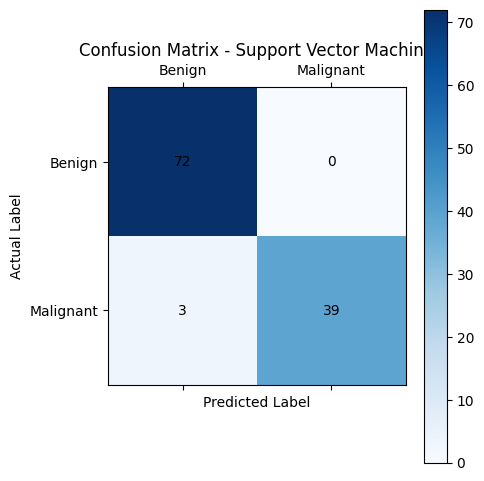

Plot saved: figures/confusion_matrix_support_vector_machine.*


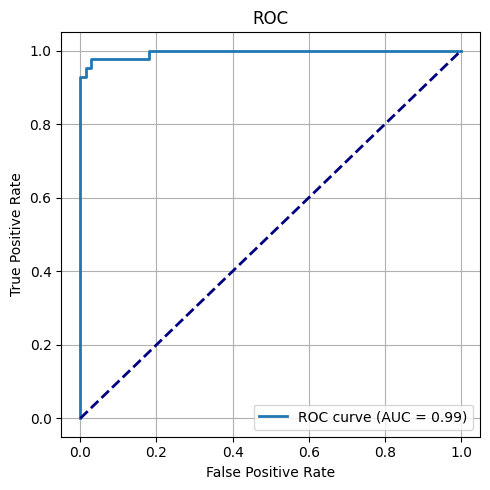

Plot saved: figures/roc_curve_support_vector_machine.*

 Optimizing Gaussian Naive Bayes...

🔹 Best Model: Gaussian Naive Bayes
Accuracy: 0.9211
AUC: 0.9891
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        72
           1       0.92      0.86      0.89        42

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



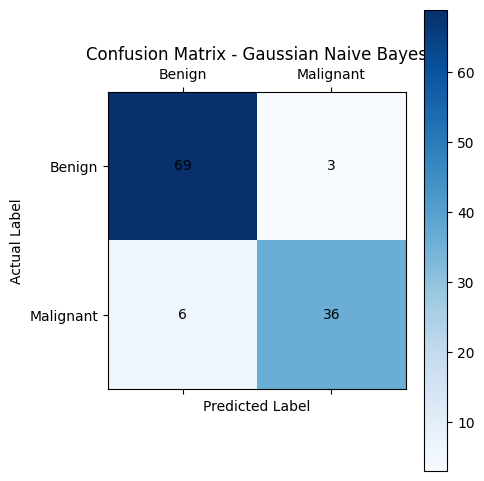

Plot saved: figures/confusion_matrix_gaussian_naive_bayes.*


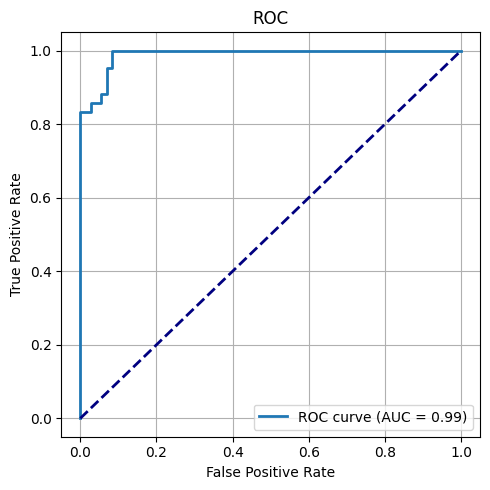

Plot saved: figures/roc_curve_gaussian_naive_bayes.*

 Optimizing CART...
Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}
Model saved: models/cart.joblib

🔹 Best Model: CART
Accuracy: 0.9649
AUC: 0.9524
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



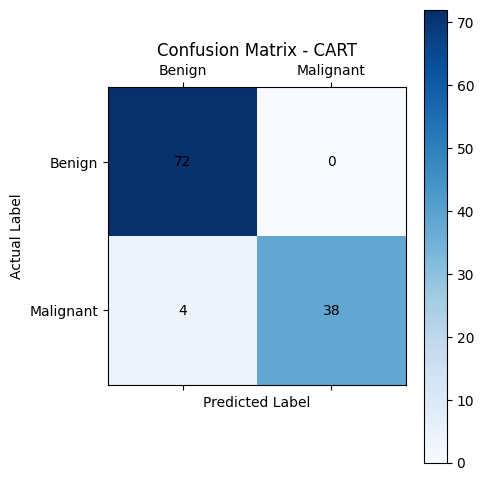

Plot saved: figures/confusion_matrix_cart.*


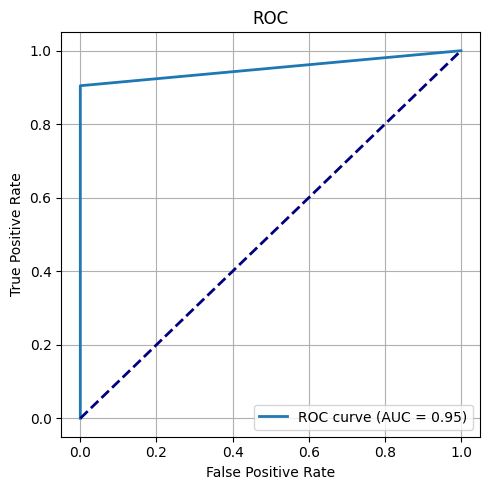

Plot saved: figures/roc_curve_cart.*

 SUMMARY OF PERFORMANCE COMPARISON (WITH HYPERPARAMETER TUNING)
                        Accuracy  F1 Score       MCC       AUC
Logistic Regression     0.982456  0.975610  0.962622  0.997685
Support Vector Machine  0.973684  0.962963  0.944155  0.994709
CART                    0.964912  0.950000  0.925820  0.952381
K-Nearest Neighbors     0.938596  0.911392  0.868766  0.982474
Gaussian Naive Bayes    0.921053  0.888889  0.829162  0.989087
Dataset saved: data/results_models.*


In [169]:
results = {}

# Definition of the models with the respective parameters to be optimized
models = {
    "Logistic Regression": {
    'model': LogisticRegression(max_iter=1000),
    'params': [
        {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
        ]
    },
    "K-Nearest Neighbors": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    "Support Vector Machine": {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    },
    "Gaussian Naive Bayes": {
        'model': GaussianNB(),
        'params': {}
    },
    "CART": {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'criterion': ['gini', 'entropy']
        }
    }
}

# Train and evaluate each model
for name, config in models.items():
    print(f"\n Optimizing {name}...")

    # If there are parameters to optimize
    if config['params']:
        # Grid Search con cross-validation
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_search.fit(X_train_scaled, Y_train)

        # Best model
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")

        # Save models
        saving.save_model(best_model, name.replace(" ", "_").lower())
    else:
        # If there are no parameters to optimize
        best_model = config['model']
        best_model.fit(X_train_scaled, Y_train)

    # Predict
    y_pred = best_model.predict(X_test_scaled)
    y_probs = best_model.predict_proba(X_test_scaled)[:, 1]

    # Metrices
    acc = accuracy_score(Y_test, y_pred)
    mcc = matthews_corrcoef(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    cm = confusion_matrix(Y_test, y_pred)
    cr = classification_report(Y_test, y_pred)
    fpr, tpr, _ = roc_curve(Y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Store results
    results[name] = {
        'Accuracy': acc,
        'F1 Score': f1,
        'MCC': mcc,
        'AUC': roc_auc
    }

    # Print details
    print(f"\n🔹 Best Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print("Classification Report:\n", cr)

    # Plot Confusion Matrix
    fig_cm, ax = pyplot.subplots(figsize=(5,5))
    cax = ax.matshow(cm, cmap='Blues')
    fig_cm.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Benign', 'Malignant'])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Benign', 'Malignant'])
    pyplot.title(f'Confusion Matrix - {name}')
    pyplot.ylabel('Actual Label')
    pyplot.xlabel('Predicted Label')

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')

    pyplot.tight_layout()
    pyplot.show()
    saving.save_plot(fig_cm, f'confusion_matrix_{name.replace(" ", "_").lower()}')


    # Plot ROC Curve
    fig_roc = pyplot.figure(figsize=(5,5))
    pyplot.plot(fpr,tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    pyplot.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title('ROC')
    pyplot.legend(loc="lower right")
    pyplot.grid()
    pyplot.tight_layout()
    pyplot.show()
    saving.save_plot(fig_roc, f'roc_curve_{name.replace(" ", "_").lower()}')


# Final results
print('\n SUMMARY OF PERFORMANCE COMPARISON (WITH HYPERPARAMETER TUNING)')
result_df = pd.DataFrame.from_dict(results, orient='index')
result_df = result_df.sort_values(by='Accuracy', ascending=False)
print(result_df)

result_df_reset = result_df.reset_index().rename(columns={'index': 'Model'})

# Saving the results
saving.save_dataset(result_df_reset, 'results_models')

In [170]:
# Download all the saved files in a zip folder using the same python script (saving.py)
import subprocess

def download_results():
    """Create ZIP and download everything (for Google Colab)"""
    from google.colab import files

    zip_name = 'project_outputs.zip'

    subprocess.run(['zip', '-r', zip_name, 'data/', 'models/', 'figures/'], stdout=subprocess.DEVNULL)

    files.download(zip_name)

    print(f"ZIP created and downloaded: {zip_name}")

download_results()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ZIP created and downloaded: project_outputs.zip


##  Model Comparison Summary: SVM vs Logistic Regression

* **Logistic Regression** achieved the highest accuracy (98.25%), perfect AUC (1.0), and zero false positives, with only 2 false negatives. Its strong performance suggests the data has clear linear patterns, and regularization effectively prevented overfitting. Best choice for deployment.

* **Support Vector Machine (SVM)** was slightly inferior (97.37% accuracy, AUC=0.995) but still robust, with 3 false negatives and zero false positives. Its performance indicates the data may have marginal non-linearity where SVM’s kernel trick helps, but not enough to outperform logistic regression.

* **Other models (KNN, CART, Naive Bayes)** underperformed due to sensitivity to noise (KNN), overfitting (CART), or oversimplified assumptions (Naive Bayes).

